## Data Balanced

In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# =============================
# Config
# =============================
RANDOM_STATE = 42
TARGET_SAMPLES_PER_CLASS = 150_000 

# =============================
# Inicializar lematizador
# =============================
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Limpia el texto:
    - Mantiene solo letras
    - Pasa a minúsculas
    - Lematiza
    - Elimina stopwords y palabras cortas
    """
    text = re.sub('[^a-zA-Z]', ' ', str(text))
    text = text.lower().split()
    text = [
        lemmatizer.lemmatize(word)
        for word in text
        if word not in set(stopwords.words('english')) and len(word) > 2
    ]
    return ' '.join(text)

# =============================
# Cargar dataset
# =============================
df = pd.read_csv("../data/merged_reviews.csv")
print("Distribución original:")
print(df['review/score'].value_counts())

# =============================
# Balancear clases (undersampling)
# =============================

# Lista para guardar samples de cada clase
balanced_list = []

# Iterar cada score de 1 a 5
for score in sorted(df['review/score'].unique()):
    class_subset = df[df['review/score'] == score]
    n_samples = min(len(class_subset), TARGET_SAMPLES_PER_CLASS)
    sampled = class_subset.sample(n=n_samples, random_state=RANDOM_STATE)
    balanced_list.append(sampled)
    print(f"Rating {score}: {len(sampled)} samples")

# Concatenar y mezclar
balanced_df = pd.concat(balanced_list).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("\nDistribución balanceada:")
print(balanced_df['review/score'].value_counts())

# =============================
# Limpieza de texto
# =============================
balanced_df["clean_summary"] = balanced_df["review/summary"].apply(clean_text)

print("\nEjemplo de resumen limpio:")
print(balanced_df[["review/summary", "clean_summary"]].head())

# =============================
# Guardar balanceado
# =============================
balanced_df.to_csv("../data/balanced_ratings.csv", index=False)
print("\n✅ Dataset balanceado guardado como 'balanced_ratings.csv'")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Distribución original:
review/score
5.0    1807099
4.0     585546
3.0     254265
1.0     201650
2.0     151033
Name: count, dtype: int64
Rating 1.0: 150000 samples
Rating 2.0: 150000 samples
Rating 3.0: 150000 samples
Rating 4.0: 150000 samples
Rating 5.0: 150000 samples

Distribución balanceada:
review/score
3.0    150000
4.0    150000
2.0    150000
1.0    150000
5.0    150000
Name: count, dtype: int64

Ejemplo de resumen limpio:
                                      review/summary  \
0                      This book needs another title   
1  Less a social commentary than an investigation...   
2                             Adventure With A Twist   
3                                   Hard To Get Into   
4                                      Good but.....   

                                       clean_summary  
0                            book need another title  
1  less social commentary investigation universal...  
2                                    adventure twist  
3       

In [24]:
print(balanced_df.head())

                                      review/summary  review/score  \
0                      This book needs another title           3.0   
1  Less a social commentary than an investigation...           4.0   
2                             Adventure With A Twist           4.0   
3                                   Hard To Get Into           3.0   
4                                      Good but.....           2.0   

                                       clean_summary  
0                            book need another title  
1  less social commentary investigation universal...  
2                                    adventure twist  
3                                           hard get  
4                                               good  


## Train

In [6]:
df = pd.read_csv("../data/balanced_ratings.csv")
print(df.columns)
# Corpus y etiquetas
corpus = df["clean_summary"].tolist()
#

print(df.isna().sum())

Index(['review/summary', 'review/score', 'clean_summary'], dtype='object')
review/summary       0
review/score         0
clean_summary     6979
dtype: int64


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mirty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-07-09 15:35:03 | INFO | 📥 Loading dataset...
2025-07-09 15:35:05 | INFO | ✅ Dataset size: 743,021 samples
2025-07-09 15:35:05 | INFO | 🔍 Preparing corpus...
2025-07-09 15:44:23 | INFO | 🧹 Vectorizing with TF-IDF...
2025-07-09 15:44:32 | INFO | ✅ Train samples: 594,416, Test samples: 148,605
2025-07-09 15:44:32 | INFO | 🔧 Setting up models...
2025-07-09 15:44:32 | INFO | 🚀 Training Logistic Regression...
2025-07-09 15:45:17 | INFO | ✅ Logistic Regression trained successfully!
2025-07-09 15:45:17 | INFO | 🚀 Training Linear SVM...
2025-07-09 15:47:49 | INFO | ✅ Linear SVM trained successfully!
2025-07-09 15:47:50 | INFO | 🚀 Training Decision Tree...
2025-07-09 15:47:56 | IN

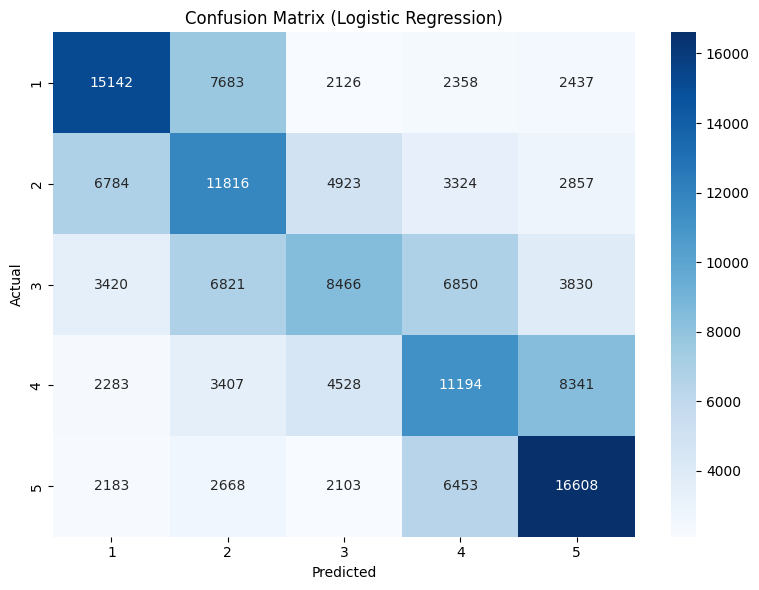

In [28]:
import logging
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from machine_learning.scripts.data_prep import prepare_corpus
#from evaluate_model import evaluate  # Si tenés una función modular

# =============================
# Setup logging
# =============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


# =============================
# Load data
# =============================
logger.info("\U0001F4E5 Loading dataset...")
dataset = pd.read_csv("../data/balanced_ratings.csv")
dataset = dataset.dropna(subset=["clean_summary", "review/score"])
dataset["clean_summary"] = dataset["clean_summary"].astype(str)
dataset["review/score"] = dataset["review/score"].astype(int)
dataset = dataset.reset_index(drop=True)
logger.info(f"✅ Dataset size: {len(dataset):,} samples")

# =============================
# Prepare corpus
# =============================
logger.info("🔍 Preparing corpus...")
corpus = prepare_corpus(dataset, "clean_summary")
labels = dataset["review/score"].values[:len(corpus)]

# =============================
# Vectorize
# =============================
logger.info("🧹 Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(corpus)
y = labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logger.info(f"✅ Train samples: {X_train.shape[0]:,}, Test samples: {X_test.shape[0]:,}")

# =============================
# Define models
# =============================
logger.info("🔧 Setting up models...")
models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=1000
    ),
    "Linear SVM": CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', max_iter=1000)
    ),
    "Decision Tree": DecisionTreeClassifier(
        class_weight='balanced', max_depth=10, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced', n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
    )
}


# =============================
# Train & evaluate
# =============================
results = []
trained_models = {}

try:
    for name, model in models.items():
        logger.info(f"🚀 Training {name}...")
        model.fit(X_train, y_train)
        logger.info(f"✅ {name} trained successfully!")

        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1": f1,
            "Precision": precision,
            "Recall": recall
        })
        trained_models[name] = model

except KeyboardInterrupt:
    logger.warning("🛑 Training interrupted by user!")
    exit()

# =============================
# Results & Save best
# =============================
df_results = pd.DataFrame(results).sort_values(by='F1', ascending=False)
logger.info("\n=== Model Results ===\n%s", df_results.to_string(index=False))

best_model_name = df_results.iloc[0]['Model']
best_model = trained_models[best_model_name]
logger.info(f"🏆 Best Model: {best_model_name}")

# =============================
# CM & Classification Report
# =============================
y_test_pred = best_model.predict(X_test)
logger.info("\n=== Classification Report ===\n%s",
            classification_report(y_test, y_test_pred, zero_division=0))

cm = confusion_matrix(y_test, y_test_pred, labels=sorted(dataset["review/score"].unique()))
logger.info(f"Confusion Matrix:\n{cm}")

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(dataset["review/score"].unique()),
            yticklabels=sorted(dataset["review/score"].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.tight_layout()
plt.show()


In [10]:
print(dataset['review/score'].value_counts())
print(dataset['review/score'].value_counts(normalize=True))

review/score
3    150000
4    150000
2    150000
1    150000
5    150000
Name: count, dtype: int64
review/score
3    0.2
4    0.2
2    0.2
1    0.2
5    0.2
Name: proportion, dtype: float64


In [11]:
print("Cantidad total de muestras:", len(dataset))

Cantidad total de muestras: 750000


2025-07-09 14:40:16 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-09 14:40:17 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


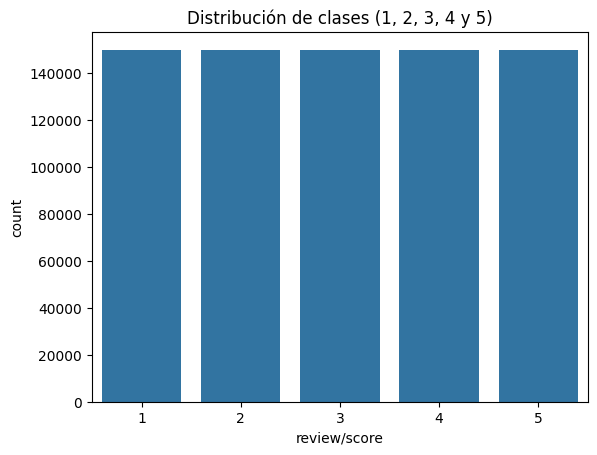

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='review/score', data=dataset)
plt.title("Distribución de clases (1, 2, 3, 4 y 5)")
plt.xticks([0,1, 2, 3, 4], ["1", "2", "3", "4", "5"])
plt.show()